# Optical Depth calculation

## 1. Prerequisites

In [5]:
import os

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.integrate import simps

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 2. Charge the data

In [6]:
nx = 480
nz = 256
ny = 480

In [7]:
data_path = "../data/"
geom_path = os.path.join(data_path, "geom_height")

In [7]:
eos = np.fromfile(os.path.join(geom_path,  "eos.080000"), dtype=np.float32)
eos = eos.reshape((2, nx, nz, ny), order = "C")
mrho= np.load(os.path.join(geom_path, "mrho_080000.npy")).reshape((nx,nz,ny))

muram_box = {
    "temperature": eos[0],
    "pressure": eos[1],
    "density": mrho
}

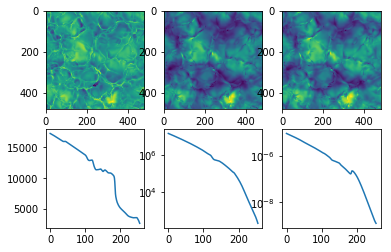

In [8]:
height = 200

fig, ax = plt.subplots(2,3)
ax[0,0].imshow(muram_box["temperature"][:,height,:])
ax[0,1].imshow(muram_box["pressure"][:,height,:])
ax[0,2].imshow(muram_box["density"][:,height,:])
ax[1,0].plot(muram_box["temperature"][100,:,100])
ax[1,1].plot(muram_box["pressure"][100,:,100])
ax[1,1].set_yscale("log")
ax[1,2].plot(muram_box["density"][100,:,100])
ax[1,2].set_yscale("log")


## 3. Calculate Optical Depth

### 3.1 Upload kappa data

In [9]:
# Define the temperature and pressure arrays
tab_T = np.array([3.32, 3.34, 3.36, 3.38, 3.40, 3.42, 3.44, 3.46, 3.48, 3.50,
                  3.52, 3.54, 3.56, 3.58, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70,
                  3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94, 3.97, 4.00,
                  4.05, 4.10, 4.15, 4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50,
                  4.55, 4.60, 4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00,
                  5.05, 5.10, 5.15, 5.20, 5.25, 5.30])

tab_p = np.array([-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5,
                  3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8.])

In [10]:
df_kappa = pd.read_csv('../csv/kappa.0.dat', delim_whitespace=True, header=None)
df_kappa.columns = ["Temperature index", "Pressure index", "Opacity value"]
temp_indices = df_kappa["Temperature index" ].unique()
press_indices = df_kappa["Pressure index"].unique()
opacity_values = df_kappa.pivot(index = "Pressure index", columns = "Temperature index", values = "Opacity value").values

temp_indices.shape, press_indices.shape, opacity_values.shape

((56,), (21,), (21, 56))

In [11]:
T = tab_T[temp_indices]
P = tab_p[press_indices]
K = opacity_values

Tg, Pg = np.meshgrid(T, P)
Tg.shape, Pg.shape

((21, 56), (21, 56))

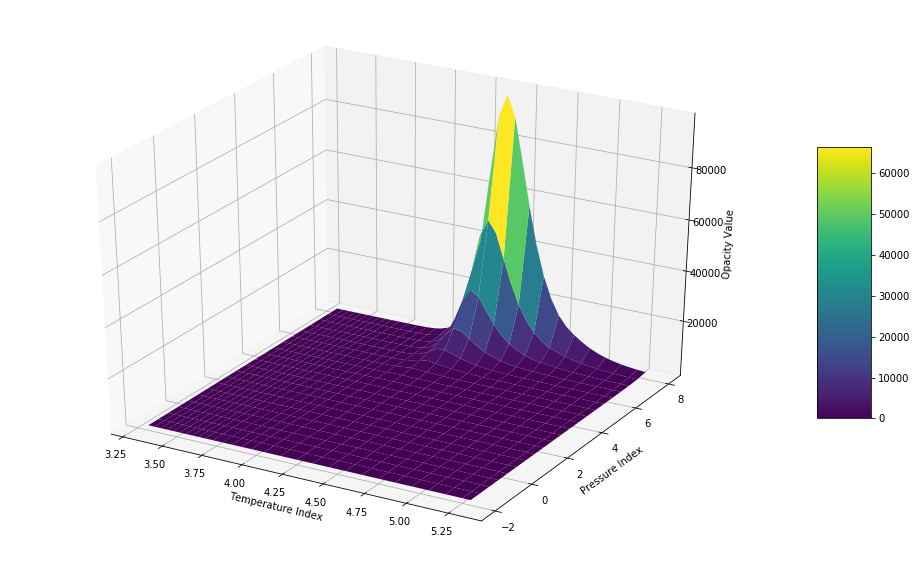

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (17,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(Tg, Pg, K, cmap='viridis')

ax.set_xlabel('Temperature Index')
ax.set_ylabel('Pressure Index')
ax.set_zlabel('Opacity Value')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


### 3.2 Kappa interpolation

Let-s apply the interpolation by using a linear method from the RegularGridInterpolator

In [13]:
kappa_interp = RegularGridInterpolator((P,T), K, method="linear")

In [14]:
T_more_p = np.linspace(Tg.min(), Tg.max(), 1000)
P_more_p = np.linspace(Pg.min(), Pg.max(), 1000)
Tg_more_p, Pg_more_p = np.meshgrid(T_more_p, P_more_p)
K_more_p = kappa_interp((Pg_more_p,Tg_more_p))

We'll plot them so that we can see if the interpolation function works well by replicating the previous plot but with more points inside our range of values of temperature and pressure.

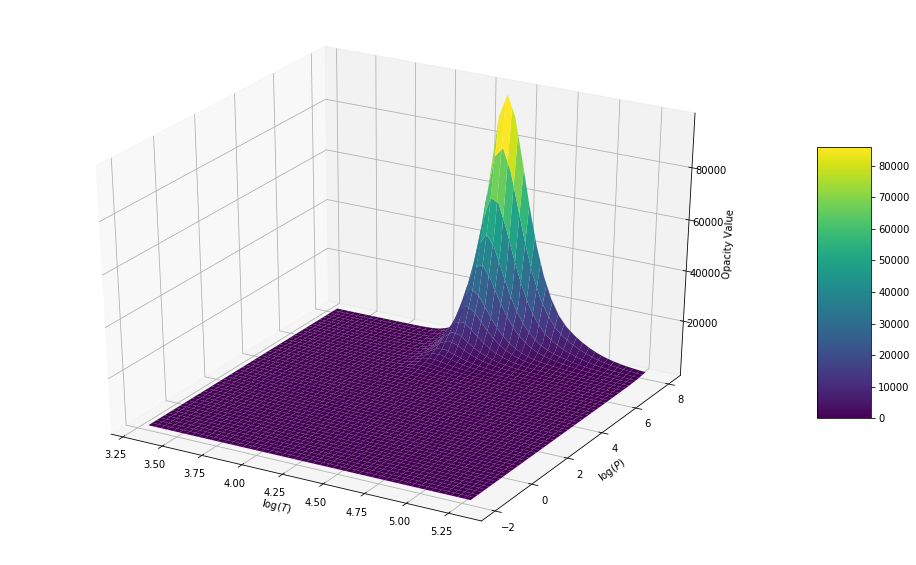

In [15]:
fig = plt.figure(figsize = (17,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(Tg_more_p, Pg_more_p, K_more_p, cmap='viridis')

ax.set_xlabel(r'$\log(T)$')
ax.set_ylabel(r'$\log(P)$')
ax.set_zlabel('Opacity Value')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


Let's create the kappa and tau arrays to save the values

In [16]:
kappa_rho = np.zeros_like(muram_box['temperature'])
tau = np.zeros_like(kappa_rho)

Perform the interpolation of the corresponding $T$ and $P$ values of your MURaM box to obtain the values of kappa for each $(x,y,z)$ point.

In [17]:
def limit_values(data, min_val, max_val):
    new_data = data.copy()
    new_data[new_data >= max_val] = max_val
    new_data[new_data <= min_val] = min_val
    print(new_data.min(), new_data.max())
    return new_data

In [18]:
T_log = np.log10(muram_box["temperature"]) 
T_log = limit_values(T_log, Tg.min(), Tg.max())
P_log = np.log10(muram_box["pressure"]) 
P_log = limit_values(P_log, Pg.min(), Pg.max())
PT_log = np.array(list(zip(P_log.flatten(), T_log.flatten())))

3.32 4.2466702
0.73977995 7.1520634


In [19]:
PT_log.shape

(58982400, 2)

Apply the interpolation and reshape to obtain the original domain size.

In [20]:
kappa_rho = kappa_interp(PT_log)
kappa_rho = kappa_rho.reshape(muram_box["temperature"].shape)
kappa_rho = np.multiply(kappa_rho, mrho)

Now we will integrate from top to bottom of the domain to obtain the corresponding optical depth values.

In [50]:
%%time
dz = 1e6 # 10 km -> 1e6 cm
tau[:,nz-1,:] = 0

print("Calculating...")
ix, iy = [100,100]
for iz in range(1,nz):
    for ix in range(nx):
        for iy in range(ny):
            kpz = kappa_rho[ix,nz-1-iz:,iy]
            tau[ix,nz-1-iz,iy] = simps(y = kpz, 
                                  dx = dz)
            
log_tau = np.log10(tau)
print("Done!")
            

Calculating...
Done!
CPU times: user 17min 44s, sys: 916 ms, total: 17min 45s
Wall time: 17min 45s


/opt/local/anaconda/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


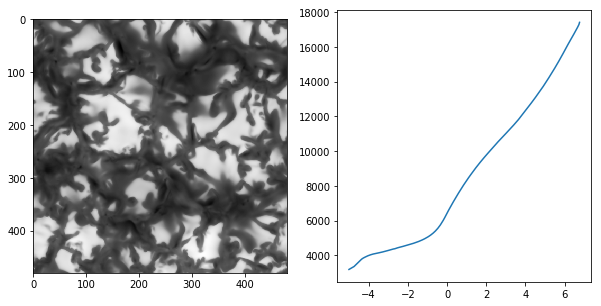

In [55]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(log_tau[:,180,:], cmap = "gist_gray")
ax[1].plot(log_tau[:,:,:].mean(axis = (0,2)),muram_box["temperature"][:,:,:].mean(axis = (0,2)))


## 4. Geometrical height to OD mapping

In [52]:
def logtau_mapper(orig_arr: np.ndarray, 
           corresp_logtau: np.ndarray,
           new_logtau: np.ndarray) -> np.ndarray:
    """
    Function for mapping the quantities distribution from geometrical height to optical depth.
    Args:
        orig_arr(np.ndarray): Original array distributed along geometrical height to be mapped.
        corresp_logtau(np.ndarray): Distribution of optical depth for the original array.
        new_logtau(np.ndarray): Array of the new optical depth measurement of height for the mapping
    Returns:
        (np.ndarray) Array containing the mapped quantity to the new distribution on optical depth.
    """
    
    logtau_mapper = interp1d(x = corresp_logtau, y = orig_arr)
    new_arr = logtau_mapper(new_logtau)
    return new_arr
    


In [53]:
logtau_height = np.linspace(-2.5, 0, 20)
n_logtau = logtau_height.shape[0]

T_tau = np.zeros((nx,n_logtau,ny))

for ix in range(nx):
    for iy in range(ny):
        T_tau[ix,:,iy] = logtau_mapper(orig_arr = muram_box["temperature"][ix,:,iy], 
                                       corresp_logtau = log_tau[ix,:,iy], 
                                       new_logtau = logtau_height)

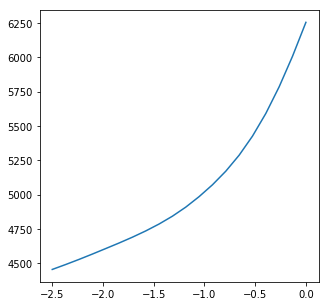

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(logtau_height, T_tau.mean(axis = (0,2)))

## 5. Creating all optical depth cubes

In [26]:
def charge_muram(filename: str, shape: tuple) -> dict:
    """
    Charges a dictionary with the thermodynamical information of the simulation.
    """
    nx, nz, ny = shape
    
    # Charge the EOS data and the density info.
    eos = np.fromfile(os.path.join(geom_path,  f"eos.{filename}"), dtype=np.float32)
    eos = eos.reshape((2, nx, nz, ny), order = "C")
    mrho= np.load(os.path.join(geom_path, f"mrho_{filename}.npy")).reshape((nx,nz,ny))
    mbxx= np.load(os.path.join(geom_path, f"mbxx_{filename}.npy")).reshape((nx,nz,ny))
    mbyy= np.load(os.path.join(geom_path, f"mbyy_{filename}.npy")).reshape((nx,nz,ny))
    mbzz= np.load(os.path.join(geom_path, f"mbzz_{filename}.npy")).reshape((nx,nz,ny))
    mvxx= np.load(os.path.join(geom_path, f"mvxx_{filename}.npy")).reshape((nx,nz,ny))
    mvyy= np.load(os.path.join(geom_path, f"mvyy_{filename}.npy")).reshape((nx,nz,ny))
    mvzz= np.load(os.path.join(geom_path, f"mvzz_{filename}.npy")).reshape((nx,nz,ny))
    
    
    # Create a dictionary for saving the quantities
    muram_box = {
        "temperature": eos[0],
        "pressure": eos[1],
        "density": mrho,
        "Bxx": mbxx,
        "Byy": mbyy,
        "Bzz": mbzz,
        "Vxx": mvxx,
        "Vyy": mvyy,
        "Vzz": mvzz
    }
    
    return muram_box

def od_cube(muram_box: dict) -> np.ndarray:
    """
    Returns an array of the same size of the domain of the MURaM simulation with the values of optical depth for each cell.
    Parameters:
        
    Returns:
            Array with the values of optical depth for each of the x,y,z positions in the domain of the simulation.
        
    """
    
    # Temperature and pressure values for the opacity interpolation
    tab_T = np.array([3.32, 3.34, 3.36, 3.38, 3.40, 3.42, 3.44, 3.46, 3.48, 3.50,
                      3.52, 3.54, 3.56, 3.58, 3.60, 3.62, 3.64, 3.66, 3.68, 3.70,
                      3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94, 3.97, 4.00,
                      4.05, 4.10, 4.15, 4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50,
                      4.55, 4.60, 4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00,
                      5.05, 5.10, 5.15, 5.20, 5.25, 5.30])

    tab_p = np.array([-2., -1.5, -1., -0.5, 0., 0.5, 1., 1.5, 2., 2.5,
                      3., 3.5, 4., 4.5, 5., 5.5, 6., 6.5, 7., 7.5, 8.])
    
    # Charging the table of temperature indices, pressure indices and opacities
    df_kappa = pd.read_csv('../csv/kappa.0.dat', delim_whitespace=True, header=None)
    df_kappa.columns = ["Temperature index", "Pressure index", "Opacity value"]
    temp_indices = df_kappa["Temperature index" ].unique()
    press_indices = df_kappa["Pressure index"].unique()
    opacity_values = df_kappa.pivot(index = "Pressure index", columns = "Temperature index", values = "Opacity value").values
    
    #Selection of the temperature and pressure values corresponding to the opacities.
    T = tab_T[temp_indices]
    P = tab_p[press_indices]
    K = opacity_values
    
    # Creation of the kappa * density and optical depth arrays for saving the values to be interpolated and calculated.
    kappa_rho = np.zeros_like(muram_box['temperature'])
    tau = np.zeros_like(kappa_rho)
    
    # Checking the values of temperature and pressure in the arrays are inside the range of valid values in the opacity table.
    def limit_values(data, min_val, max_val):
        new_data = data.copy()
        new_data[new_data >= max_val] = max_val
        new_data[new_data <= min_val] = min_val
        return new_data
    
    T_log = np.log10(muram_box["temperature"]) 
    T_log = limit_values(T_log, T.min(), T.max())
    P_log = np.log10(muram_box["pressure"]) 
    P_log = limit_values(P_log, P.min(), P.max())
    PT_log = np.array(list(zip(P_log.flatten(), T_log.flatten())))
    print(f"Interpolating {filename} kappa...")
    # kappa values interpolated and multiplied by the density.
    kappa_interp = RegularGridInterpolator((P,T), K, method="linear")
    kappa_rho = kappa_interp(PT_log)
    kappa_rho = kappa_rho.reshape(muram_box["temperature"].shape)
    kappa_rho = np.multiply(kappa_rho, mrho)
    
    # Optical depth array calculation
    dz = 1e6 # 10 km -> 1e6 cm
    tau[:,nz-1,:] = 0

    print(f"Calculating {filename} tau...")
    for iz in range(1,nz):
        if iz % 50 == 0:
            print("height: ", iz)
        for ix in range(nx):
            for iy in range(ny):
                kpz = kappa_rho[ix,nz-1-iz:,iy]
                tau[ix,nz-1-iz,iy] = simps(y = kpz, 
                                      dx = dz)

    log_tau = np.log10(tau)
    print("log tau Done!")
    
    np.save(os.path.join(geom_path, f"log_tau_{filename}.npy"), log_tau)


In [22]:
filenames = ["080000", "085000", "090000", "095000", "100000", "105000", "110000", "130000", "175000"]



for fln in filenames:
    muram_box = charge_muram(fln, (nx,ny,nz))
    od_cube(muram_box)

Interpolating 110000 kappa...
Calculating 110000 tau...
height:  50
height:  100
height:  150
height:  200
height:  250


/opt/local/anaconda/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10


log tau Done!
Interpolating 175000 kappa...
Calculating 175000 tau...
height:  50
height:  100
height:  150
height:  200
height:  250
log tau Done!


In [53]:
opt_path = os.path.join(data_path, "optical_depth")

def charge_logtau(filename: str, shape: tuple):
    """
    Charges the distribution of log optical depth for the original MURaM simulation domain.
    """
    # optical depth values distributed on the original domain of MURaM
    nx,nz,ny = shape
    muram_logtau = np.load(os.path.join(geom_path, f"log_tau_{filename}.npy")).reshape((nx,nz,ny))
    return muram_logtau

def map_to_logtau(muram_quantity: np.ndarray, muram_logtau: np.ndarray, output_name: str) -> np.ndarray:
    """
    Returns an array of the same size of the domain of the MURaM simulation with the values of the data mapped to log tau.
    Parameters:
        
    Returns
        out: np.ndarray
            Array of the atmosphere magnitudes re mapped to optical depth stratification.
        
    """
    
    def logtau_mapper(orig_arr: np.ndarray, 
               corresp_logtau: np.ndarray,
               new_logtau: np.ndarray) -> np.ndarray:
        """
        Function for mapping the quantities distribution from geometrical height to optical depth.
        Args:
            orig_arr(np.ndarray): Original array distributed along geometrical height to be mapped.
            corresp_logtau(np.ndarray): Distribution of optical depth for the original array.
            new_logtau(np.ndarray): Array of the new optical depth measurement of height for the mapping
        Returns:
            (np.ndarray) Array containing the mapped quantity to the new distribution on optical depth.
        """

        logtau_mapper = interp1d(x = corresp_logtau, y = orig_arr)
        new_arr = logtau_mapper(new_logtau)
        return new_arr
    
    # New optical depth stratification array.
    new_logtau_height = np.linspace(-2.5, 0, 20)
    n_logtau = new_logtau_height.shape[0]

    # Mapping to the new optical depth stratification
    quantity_tau = np.zeros((nx,n_logtau,ny))
    for ix in range(nx):
        if ix % 100 == 0:
            print(ix)
        for iy in range(ny):
            quantity_tau[ix,:,iy] = logtau_mapper(orig_arr = muram_quantity[ix,:,iy], 
                                           corresp_logtau = muram_logtau[ix,:,iy], 
                                           new_logtau = new_logtau_height)
    
    output_path = os.path.join(opt_path, output_name)
    np.save(output_path, quantity_tau.flatten())
    print(f"saved in {output_path}")
            
    

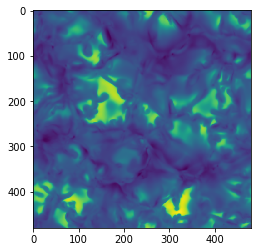

In [44]:
plt.imshow(charge_logtau(filename = "080000", shape = (nx,nz,ny))[:,185,:])

In [56]:
filenames = ["175000"]
output_names = ["mtpr", "mpre", "mrho", "mbxx", "mbyy", "mbzz", "mvxx", "mvyy", "mvzz"]

for fln in filenames:
    muram_box = charge_muram(fln, (nx,nz,ny))
    muram_logtau = charge_logtau(fln, (nx,nz,ny))
    for quantity, out_name in list(zip(muram_box.keys(), output_names)):
        print(f"Mapping {fln} {quantity} to log tau...")
        map_to_logtau(muram_quantity = muram_box[quantity], 
                      muram_logtau = muram_logtau,
                      output_name  = f"{out_name}_logtau_{fln}.npy")
        print("Done!")

Mapping 175000 temperature to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mtpr_logtau_175000.npy
Done!
Mapping 175000 pressure to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mpre_logtau_175000.npy
Done!
Mapping 175000 density to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mrho_logtau_175000.npy
Done!
Mapping 175000 Bxx to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mbxx_logtau_175000.npy
Done!
Mapping 175000 Byy to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mbyy_logtau_175000.npy
Done!
Mapping 175000 Bzz to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mbzz_logtau_175000.npy
Done!
Mapping 175000 Vxx to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mvxx_logtau_175000.npy
Done!
Mapping 175000 Vyy to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mvyy_logtau_175000.npy
Done!
Mapping 175000 Vzz to log tau...
0
100
200
300
400
saved as ../data/optical_depth/mvzz_logtau_1

In [64]:
def charge_logtau_muram(filename: str, shape: tuple) -> dict:
    """
    Charges a dictionary with the thermodynamical information of the simulation.
    """
    nx, nz, ny = shape
    
    # Charge the EOS data and the density info.
    mtpr = np.load(os.path.join(opt_path, f"mtpr_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mpre = np.load(os.path.join(opt_path, f"mpre_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mrho= np.load(os.path.join(opt_path, f"mrho_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mbxx= np.load(os.path.join(opt_path, f"mbxx_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mbyy= np.load(os.path.join(opt_path, f"mbyy_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mbzz= np.load(os.path.join(opt_path, f"mbzz_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mvxx= np.load(os.path.join(opt_path, f"mvxx_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mvyy= np.load(os.path.join(opt_path, f"mvyy_logtau_{filename}.npy")).reshape((nx,nz,ny))
    mvzz= np.load(os.path.join(opt_path, f"mvzz_logtau_{filename}.npy")).reshape((nx,nz,ny))
    
    
    # Create a dictionary for saving the quantities
    muram_box = {
        "temperature": mtpr,
        "pressure": mpre,
        "density": mrho,
        "Bxx": mbxx,
        "Byy": mbyy,
        "Bzz": mbzz,
        "Vxx": mvxx,
        "Vyy": mvyy,
        "Vzz": mvzz
    }
    
    return muram_box

In [67]:
logtau = np.linspace(-2.5, 0, 20)
muram_logtau_box = charge_logtau_muram("080000", (nx,logtau.shape[0],ny))

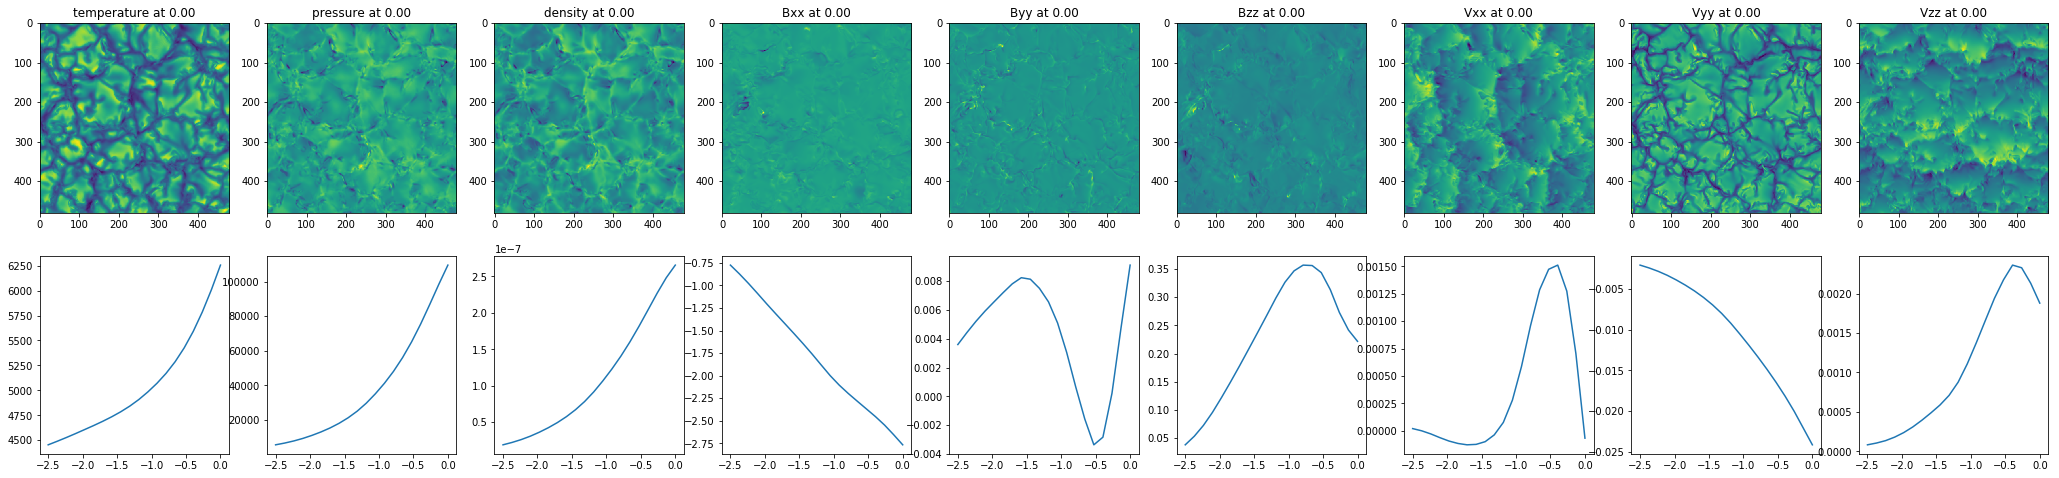

In [78]:
fig, ax = plt.subplots(2,9,figsize=(9*4,4*2))
i = 0
i_logt = 19
cmaps
for quantity in muram_logtau_box.keys():
    ax[0,i].imshow(muram_logtau_box[quantity][:,i_logt,:])
    ax[0,i].set_title(f"{quantity} at {logtau[i_logt]:0.2f}")
    ax[1,i].plot(logtau, muram_logtau_box[quantity].mean(axis=(0,2)))
    i += 1